# Sonar data analysis

This Jupyter Notebook analyzes sonar data from a `.sl2` file, including loading, visualizing, clustering, and specific cluster analysis. 

The primary channel data is scaled and clustered using K-means. A specific cluster is analyzed for plant height (note that this is only an example as the sonar image does not appear to contain any larger plants), which is visualized and added to a DataFrame. The final data, including plant height and cluster labels, is saved to a CSV file.


In [1]:
import sonarlight
from sonarlight import Sonar
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import random

random.seed(9999)
np.random.seed(9999)

print(sonarlight.__version__)

0.1.7


## Load data

In [10]:
#Read data from a '.sl2' or '.sl3' file
sl2 = Sonar('../example_files/example_sl2_file.sl2')

## Plot data

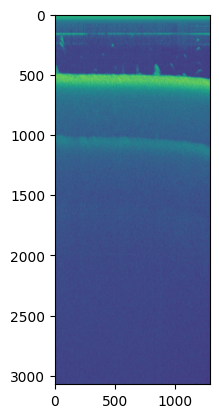

In [11]:
#Plot primary channel
prim = sl2.image("primary")
plt.imshow(prim.transpose())

(1288, 400)


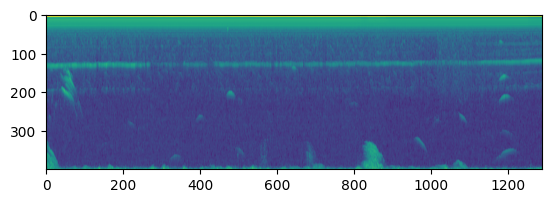

In [12]:
water = sl2.water(channel="primary", pixels=400)
plt.imshow(water.transpose())
print(water.shape)

## Primary channel analysis

In [28]:
# Perform scaling and K-means clustering 
scaler = StandardScaler()
scaler_trained = scaler.fit(water)

water_scaled = scaler_trained.transform(water)

n_clusters = 4 
kmeans = KMeans(n_clusters=n_clusters).fit(water_scaled)

In [29]:
# Apply to data
water_cat_scaled = scaler_trained.transform(water)

labels = kmeans.predict(water_cat_scaled)
labels.shape

(1288,)

In [30]:
# Count observations per cluster
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int32), array([412,  68, 775,  33]))

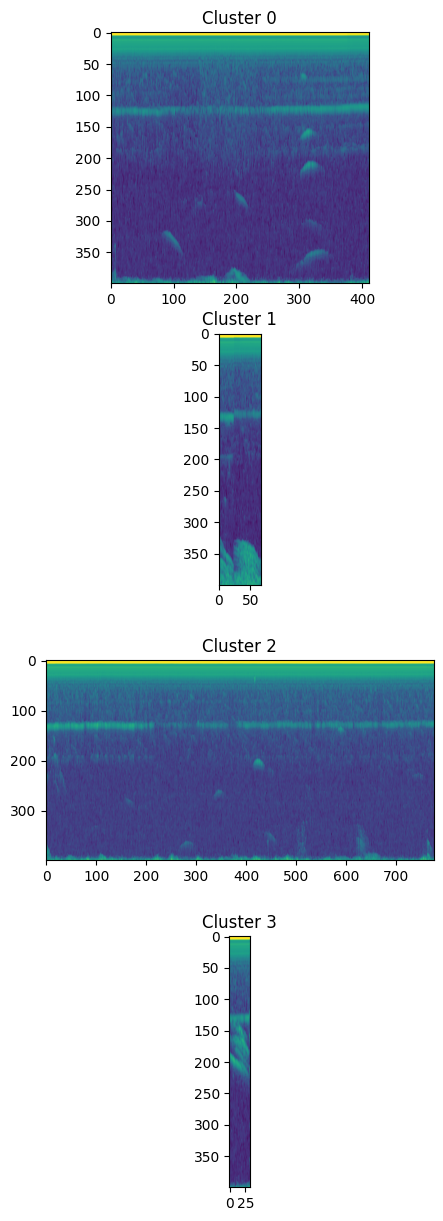

In [32]:
#Plot examples of water column sonar imagery for each cluster
fig, axs = plt.subplots(n_clusters, 1, figsize=(5, 15))
for i in range(n_clusters):
    axs[i].imshow(water[labels == i].transpose())
    axs[i].set_title(f"Cluster {i}")
plt.show()


In [86]:
# Analyse plant height for a specific cluster
# (note that this is only an example as the sonar image does not appear to contain any larger plants)
def analyze_plant_height(water_cat_plants, threshold):
    num_channels = water_cat_plants.shape[1]
    
    # Normalize by subtracting mean
    # This step centers the data around zero by subtracting the mean value of each column
    water_cat_plants_norm = water_cat_plants - water_cat_plants.mean(axis=0)
    
    # Find argmax for each row
    # This step identifies the index of the maximum value in each row, which corresponds to the plant height
    plant_index = np.argmax(water_cat_plants_norm, axis=1)
    
    # Get the maximum value in each row
    plant_value = np.max(water_cat_plants_norm, axis=1)

    # Apply threshold to filter out low values
    # If the maximum value is below the threshold, set the index to the number of channels
    plant_index[plant_value < threshold] = num_channels
    
    # Calculate plant height proportion
    # This step converts the index to a proportion of the total number of channels
    plant_prop_height = plant_index / num_channels

    return plant_prop_height

# Extract plant cluster (select based on visual inspection)
PLANT_CLUSTER_ID = 1
water_plants = water[(labels==PLANT_CLUSTER_ID)]

# Analyze plant height
THRESHOLD = 35
plant_prop_height = analyze_plant_height(water_plants, threshold=THRESHOLD)


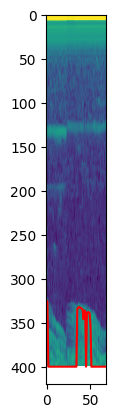

In [87]:
# Plot image of cluster with plant height as red line
plt.imshow(water_plants.transpose())
plt.plot(plant_prop_height * water.shape[1], color='red')
plt.show()

In [88]:
# Extract df
df = sl2.df
df = df[df["survey"] == "primary"].copy()

# Determine bottom index
bottom_intensity = np.array([f[i] for f, i in zip(df["frames"], df["bottom_index"])])

# Create column with plant height (fraction of water column)
df["plant_height_prop"] = 0.0
df.loc[labels==PLANT_CLUSTER_ID, "plant_height_prop"] = (1-plant_prop_height) # Invert plant height to 'height above bottom'

# Add labels and bottom intensity to dataframe
df["labels"] = labels
df["bottom_intensity"] = bottom_intensity

# Finally, save the data to a csv file
df[["x", "y", "longitude", "latitude", "water_depth", "labels", "bottom_intensity", "plant_height_prop"]].drop_duplicates().to_csv("sl2_primary_data.csv", index=False)